In [1]:
import os

import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import captum.attr 

from IPython.display import display, HTML

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yldx2p_p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
home_dir = '/home/luxburg/fgoeppert26/'
torch.hub.set_dir(home_dir+'.local/.cache/torch')

device = torch.device('cpu')
print(device)

cpu


In [3]:
def generate_attributions(examples, baselines, model_dict, method_dict):
    
    model_attributions = {}
   
    examples.to(device)
    examples = examples.double()
    if baselines is None:
        baselines = torch.rand((5,examples.shape[1],examples.shape[2],examples.shape[3]))
    baselines.to(device)
    
    for model_name, model in model_dict.items():
        print(f'{model_name}:')
        model_attributions[model_name] = []
        
        model.to(device) 
        model = model.double()
        model = model.eval()
        
        targets = model(examples).argmax(1).to(device)
        
        #print(targets)
            
        attributions = {}
        for method_name, method in method_dict.items():
            meth = method[0](model) 
            if method[1]: 
                attr = meth.attribute(examples, baselines, target = targets, n_samples=5, stdevs=1.0) 
            else:
                if method_name == 'gradient':
                    attr = meth.attribute(examples, target = targets, abs = False)
                else:
                    attr = meth.attribute(examples, target = targets)
                    
            attributions[method_name] = attr.cpu().detach().numpy()
            print(f'\t {method_name} done!')
            
        model_attributions[model_name] = attributions 
        model.to('cpu')
        
    return model_attributions    

In [4]:
# load some images from the imagenet validation set
imagenet_dir = '/mnt/qb/datasets/ImageNet2012/val/n01531178' # set this accordingly

examples = []
for file in os.listdir(imagenet_dir):
    im = Image.open(imagenet_dir+'/'+file)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    ])
    im = transform(im)
    examples.append(im)


examples = torch.stack(examples)
idx = [46,18,13]
pkl.dump(examples[idx],open(f'data/examples.pkl', 'wb'))

In [5]:
# explain some examples using different models and methods

examples = pkl.load(open(f'data/examples.pkl', 'rb'))
baselines = None
model_dict = {'alexnet': models.alexnet(pretrained=True),
              'vgg16': models.vgg16(pretrained=True),
              'squeezenet': models.squeezenet1_0(pretrained=True),
              'shufflenet': models.shufflenet_v2_x1_0(pretrained=True),
              'resnet18':models.resnet18(pretrained=True),
              'wide_resnet50_2': models.wide_resnet50_2(pretrained=True),
              'inception': models.inception_v3(pretrained=True),
              'resnext50_32x4d': models.resnext50_32x4d(pretrained=True),
              'googlenet': models.googlenet(pretrained=True),
              'mnasnet': models.mnasnet1_0(pretrained=True)
             }
method_dict = {'gradient': (captum.attr.Saliency,False), 
               'input x gradient': (captum.attr.InputXGradient,False),
               'guided backprop': (captum.attr.GuidedBackprop, False),
               'gradient shap': (captum.attr.GradientShap,True),
               }

model_attributions = generate_attributions(normalize(examples), baselines, model_dict, method_dict)

alexnet:


/home/luxburg/fgoeppert26/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


	 gradient done!
	 input x gradient done!


/home/luxburg/fgoeppert26/.local/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


	 guided backprop done!
	 gradient shap done!
vgg16:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
squeezenet:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
shufflenet:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
resnet18:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
wide_resnet50_2:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
inception:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
resnext50_32x4d:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
googlenet:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!
mnasnet:
	 gradient done!
	 input x gradient done!
	 guided backprop done!
	 gradient shap done!


In [6]:
# average attributions
def generate_average_attributions(model_attributions):
    mean_attributions = {}
    for method_name in next(iter(model_attributions.values())):
        method_attributions = [model_attributions[model_name][method_name] for model_name in model_attributions]
        mean_attributions[method_name] = np.mean(np.array(method_attributions),axis = 0)
    return mean_attributions

In [7]:
# e.g. as extra entry
model_attributions['mean attributions'] = generate_average_attributions(model_attributions)

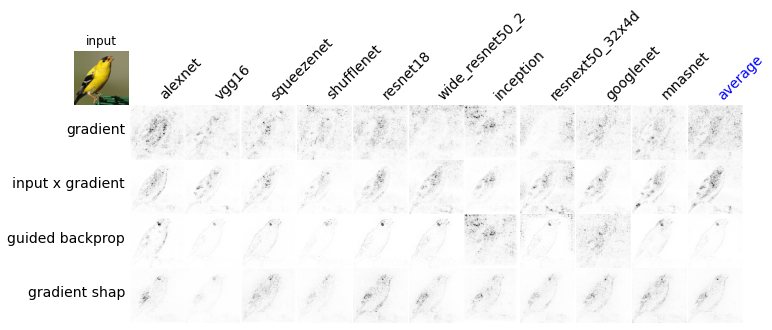

In [10]:
# plot example and its attributions

i = 0
im = examples[i]
n_models = len(model_dict)
n_methods = len(method_dict) 

fig, ax = plt.subplots(nrows= n_methods+1,ncols = n_models+2, figsize=(12,5))
c = 0                 
r = 0            
ax[r,c].imshow(im.permute(1,2,0), vmin=im.min(), vmax=im.max())
ax[r,c].set_title('input')


for a in ax.flat:
    a.axis('off')

for model_name, attributions in model_attributions.items():
    c += 1 
    r = 0
    color = 'black'
    if model_name == 'mean attributions':
        color = 'blue'
        model_name = 'average'

    for method_name,attr in attributions.items():
        r += 1

        a = abs(np.sum(attr[i],axis = 0)) # sum attributions over channels
        
        ax[r,c].imshow(a,cmap = 'Greys', vmax =a.max()*0.5)
        if c == 1:
            ax[r,c].text(-20,100,f'{method_name}',fontsize = 14,va = 'center', ha = 'right')
        if r == 1:
            ax[r,c].set_title(f'{model_name}', fontsize = 14, rotation=45, ha ='left', color = color)
            
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
plt.savefig(f'figures/imagenet_{i}.pdf',bbox_inches='tight',pad_inches=0.01)
plt.show()       